In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# Unstructured grid interpolator function availiable on scipy
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

from read_atmospheric_var import get_points_df

In [23]:
estaciones_xls = 'informacion_estaciones_red_calidad_aire.xls'
air_data_h5 = 'air_quality.h5'

year, month, day, hour = 2024, 8, 7, 9
atm_var = 12

# Get dataframe with station, coords, and variable at selected time point
df = get_points_df(year, month, day, hour, atm_var, air_data_h5, estaciones_xls)

In [24]:
# --- Interpolator function ---
# interp = LinearNDInterpolator(list(zip(df.lon, df.lat)), df.z)  # Linear - QHULL
interp = CloughTocher2DInterpolator(list(zip(df.lon, df.lat)), df.z)  # Cubic interpolator

# Square grid - 200 points
Xv = np.linspace(min(df.lon), max(df.lon), 200)
Yv = np.linspace(min(df.lat), max(df.lat), 200)
X, Y = np.meshgrid(Xv, Yv)  # 2D grid for interpolation

# Apply function
Z = interp(X, Y)

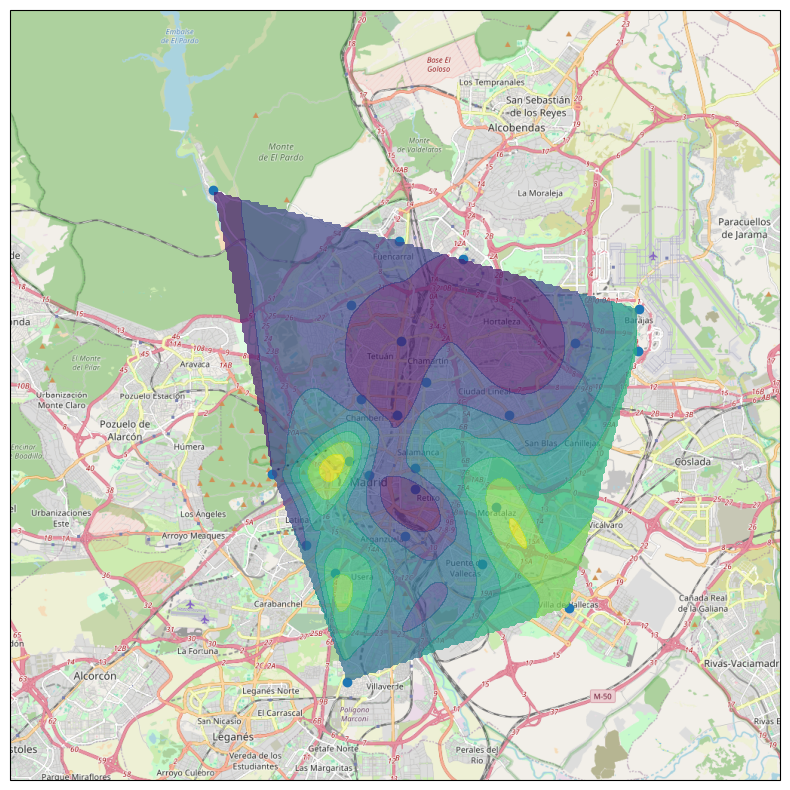

In [34]:
# Define coordinates for Madrid [lon, lat]
estaciones = pd.read_excel(estaciones_xls)
lons = estaciones.LONGITUD
lats = estaciones.LATITUD
center = (lons.mean(), lats.mean())  # (longitude, latitude)

# Define OpenStreetMap as tile source
osm_tiles = cimgt.OSM()

# Set up projection and plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=osm_tiles.crs)


# # Define extent around Madrid (in lon/lat)
# extent = [estaciones.LONGITUD.min(), estaciones.LONGITUD.max(),
#           estaciones.LATITUD.min(), estaciones.LATITUD.max()]
# ax.set_extent(extent, crs=ccrs.Geodetic())
# -- Automatic extent set with the contour plot

# Add OSM tiles
ax.add_image(osm_tiles, 12)  # Higher zoom number = more detail

# Define source and target projections
src_crs = ccrs.Geodetic()         # Geographic (lon/lat)
dst_crs = osm_tiles.crs # ccrs.Mercator()         # Mercator (same as osm_tiles.crs)

# Transform station coordinate points
x, y = dst_crs.transform_points(src_crs, lons, lats)[:, 0], dst_crs.transform_points(src_crs, lons, lats)[:, 1]
ax.scatter(x,y)

#tranform for the contour
Xt, Yt = dst_crs.transform_points(src_crs, X.flatten(), Y.flatten())[:, 0], dst_crs.transform_points(src_crs,  X.flatten(), Y.flatten())[:, 1]
Xt=Xt.reshape(X.shape)
Yt=Yt.reshape(Y.shape)

ax.contourf(Xt, Yt, Z, alpha=0.7) # , shading='auto')
